<a href="https://colab.research.google.com/github/samantaheri71/Dynamic-Line-Forecasting/blob/main/EMD_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 7.8MB/s 


In [ ]:

%tensorflow_version 2.x
import tensorflow as tf
print(tf.version)
import os
import math
import numpy as np
from tensorflow import keras
#from keras.preprocessing.sequence import TimeSeriesGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
#from Ipython.display import clear_output
import tensorflow.compat.v2.feature_column as fc
from tensorflow.keras.utils import plot_model
import pandas as pd
import seaborn as sns
sns.set_style('white')

import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import tensorflow.compat.v2.feature_column as fc
from tensorflow.keras.utils import plot_model
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


# lstm for time series forecasting
from numpy import sqrt
from numpy import asarray
from pandas import read_csv
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import concatenate

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
from google.colab import files
uploaded = files.upload() # u can now upload the datasetst

Saving DLR.csv to DLR.csv


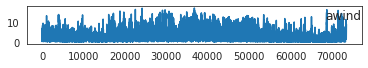

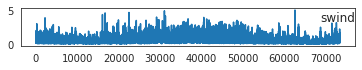

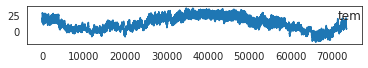

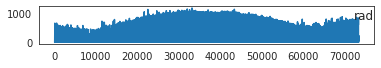

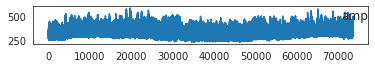

In [ ]:
import io
from matplotlib import pyplot
dataset=pd.read_csv(io.BytesIO(uploaded["DLR.csv"]),header=0, squeeze=True) 
dataset=dataset.drop(columns="direction")

values = dataset.values[:73500,:]
#specify columns to plot
groups = [0,1,2, 3,4]
i = 1
#plot each column
pyplot.figure()
for group in groups:
  pyplot.subplot(len(groups), 1, i)
  pyplot.plot(values[:, group])
  pyplot.title(dataset.columns[group], y=0.5, loc='right')
  i += 1
  pyplot.show()

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning

reframed = series_to_supervised(dataset, 10, 1)
reframed.columns
reframed.drop(reframed.columns[[51,52,53,54]], axis=1, inplace=True)
reframed.columns

Index(['var1(t-10)', 'var2(t-10)', 'var3(t-10)', 'var4(t-10)', 'var5(t-10)',
       'var1(t-9)', 'var2(t-9)', 'var3(t-9)', 'var4(t-9)', 'var5(t-9)',
       'var1(t-8)', 'var2(t-8)', 'var3(t-8)', 'var4(t-8)', 'var5(t-8)',
       'var1(t-7)', 'var2(t-7)', 'var3(t-7)', 'var4(t-7)', 'var5(t-7)',
       'var1(t-6)', 'var2(t-6)', 'var3(t-6)', 'var4(t-6)', 'var5(t-6)',
       'var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)',
       'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)', 'var5(t-4)',
       'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)',
       'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var1(t)'],
      dtype='object')

In [ ]:
values = reframed.values

#standardization of the data
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
values=scaler.fit_transform(values)
print(values.shape)


#split to train and test
n_train_hours = 408 * 24* 6
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(73490, 51)
(58752, 1, 50) (58752,) (14738, 1, 50) (14738,)


Model: "DRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1, 50)]           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 60)             26400     
_________________________________________________________________
dense_13 (Dense)             (None, 1, 1)              61        
Total params: 26,461
Trainable params: 26,461
Non-trainable params: 0
_________________________________________________________________


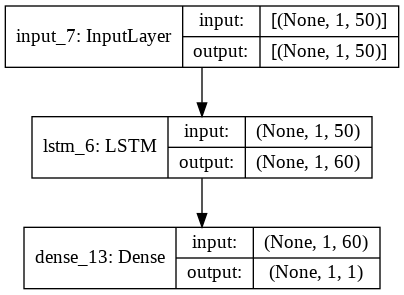

In [ ]:
lstm = tf.keras.layers.LSTM(                                                       units=60,  #	Positive integer, dimensionality of the output space.
                            activation='tanh', recurrent_activation='sigmoid', use_bias=False,  #  Activation functions to use. 
                                                                                 dropout=0.1,  #Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
                                                                      return_sequences=True,)  #Boolean. Whether to return the last output. in the output sequence, or the full sequence.
                                                                      
mlp1 = tf.keras.layers.Dense(100, activation="sigmoid")
mlp2 = tf.keras.layers.Dense(1, activation="sigmoid")


inputs = keras.Input(shape=(train_X.shape[1], train_X.shape[2]))
x0=lstm(inputs)
x1=mlp2(x0)
DRNN_model = keras.Model(inputs=inputs, outputs=x1, name="DRNN")
DRNN_model.summary()
plot_model(DRNN_model, to_file="DRNN_model.png", show_shapes=True)

In [ ]:
rmse = tf.keras.metrics.RootMeanSquaredError()
DRNN_model.compile( optimizer=keras.optimizers.Nadam(learning_rate=1e-3,beta_1=0.9, beta_2=0.999, epsilon=1e-07),
                loss="mean_squared_error",
                metrics=[rmse])

Epoch 1/50
11751/11751 - 21s - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0469

Epoch: 0, loss:0.0056,  root_mean_squared_error:0.0750,  val_loss:0.0022,  val_root_mean_squared_error:0.0469,  
.Epoch 2/50
11751/11751 - 19s - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
.Epoch 3/50
11751/11751 - 19s - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
.Epoch 4/50
11751/11751 - 19s - loss: 0.0032 - root_mean_squared_error: 0.0567 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
.Epoch 5/50
11751/11751 - 19s - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403
.Epoch 6/50
11751/11751 - 19s - loss: 0.0028 - root_mean_squared_error: 0.0533 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
.Epoch 7/50
11751/11751 - 19s - loss: 0.0028 - root_mean_squared_error:

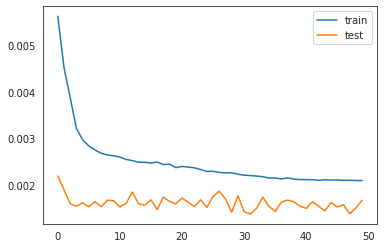

In [ ]:


EPOCHS= 50

history = DRNN_model.fit(train_X, train_y,
                   validation_data=(test_X, test_y),
                   epochs=EPOCHS,
                   verbose=2, shuffle=False,
                  batch_size=3, # you can use the make_input_fn as well.
                  callbacks=[tfdocs.modeling.EpochDots()])

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))


y_prediction = DRNN_model.predict(test_X)
y_prediction=y_prediction.reshape(-1)


print(mean_squared_error(y_prediction, test_y))
print(mean_absolute_percentage_error(y_prediction, test_y))
print(r2_score(y_prediction, test_y))
print(mean_absolute_error(y_prediction, test_y))
y_prediction.shape

0.0016773691883393872
0.28989714195697325
0.8489764912324507
0.029846499082407364


(14738,)

In [ ]:
horizon = {'prediction_LSTM': y_prediction,
           'Ground_data':test_y,
        }

df = pd.DataFrame(horizon, columns= ['prediction_LSTM','Ground_data'])
df.to_csv (r'C:\Users\surface\Desktop\Python\Load_data.csv', index = False, header=True)
df.to_csv('DLR_LSTM.csv', index = False, header=True)

#files.download("DLR_LSTM.csv")
df.describe()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,prediction_LSTM,Ground_data
count,14738.000000,14738.000000
mean,0.136914,0.152099
std,0.103339,0.122687
min,0.007223,0.000000
25%,0.075525,0.071429
50%,0.104021,0.119048
75%,0.159587,0.190476
max,0.804896,0.952381


In [ ]:
# make a prediction
yhat = DRNN_model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)

ValueError: ignored